# Building the chatbot

### Import the libraries and dependencies

In [ ]:
import json
import requests
import os
import numpy as np
from langchain_aws import ChatBedrock
from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
import boto3
import opik
from opik import track
from datetime import datetime
import uuid
from dotenv import load_dotenv
import vertexai
from vertexai.preview.language_models import TextEmbeddingModel
import time
from decimal import Decimal
import asyncio
import threading
from concurrent.futures import ThreadPoolExecutor

load_dotenv()



separator = "=================================================="

## Load bedrock models 

I decided to use claude-3-5-sonnet from anthropic as the primary option and llama as a fallback model for several reasons :

* Claude 3.5 Sonnet (primary model)

- High-quality reasoning & context handling : Claude 3.5 Sonnet is one of the strongest models on AWS Bedrock for complex reasoning, nuanced answers, and maintaining context over longer conversations — exactly what we want in a chatbot.

- Safety & alignment : Anthropics’ Claude models are designed with strong alignment and safety mechanisms. They’re less likely to produce harmful or nonsensical outputs, making them a good first-line choice for production chatbots.

- Balanced performance : Sonnet sits between the lighter Haiku and the heavier Opus models — giving a good balance of speed and intelligence, so the chatbot feels responsive but still smart.

- Natural, conversational tone : Claude has a reputation for sounding more “human-like,” with coherent, polite, and engaging responses — which improves user experience in chatbots.

* LLaMA 3.2 1B Instruct (fallback model)

Lightweight & efficient
The 1B parameter size makes it much cheaper and faster to run compared to larger models, perfect as a backup when Claude isn’t available (or for cost-saving in non-critical requests).

Instruction-tuned for chat
The "Instruct" variant is optimized for following user commands and short Q&A — so even though it’s smaller, it can still handle many chatbot scenarios decently well.

Open-weight flexibility
Meta’s LLaMA models are widely adopted in the open-source community, meaning we could later fine-tune, distill, or extend it if you want more control over our fallback model.

Resiliency in production
Having a smaller fallback ensures that the chatbot always has an answer — even if the primary model is down, rate-limited, or too expensive for a burst of traffic.

In [ ]:
def load_bedrock_models():
    """Initialize Bedrock models and return them"""
    try:
        bedrock_client = boto3.client('bedrock-runtime', region_name='us-east-1')
        
        claude_model = ChatBedrock(
            client=bedrock_client,
            model_id='anthropic.claude-3-5-sonnet-20240620-v1:0',
            model_kwargs={"max_tokens": 1000, "temperature": 0.7, "top_p": 0.9}
        )
        
        llama_model = ChatBedrock(
            client=bedrock_client,
            model_id='meta.llama3-2-1b-instruct-v1:0',
            model_kwargs={"max_tokens": 1000, "temperature": 0.7, "top_p": 0.9}
        )
        
        print("Bedrock models initialized successfully")
        return claude_model, llama_model
    except Exception as e:
        print(f"Error initializing Bedrock: {e}")
        return None, None

In [ ]:
claude_model, llama_model = load_bedrock_models()

### Setup DynamoDB Client

We will use DynamoDB to save the history of our chatbot sessions 

In [ ]:
def setup_dynamodb():
    """Initialize and return DynamoDB chat table"""
    dynamodb_table_name = os.environ.get("DYNAMO_DB_TABLE_NAME")
    dynamodb = boto3.resource("dynamodb", region_name="us-east-1")  # change region if needed
    chat_table = dynamodb.Table(dynamodb_table_name)  # make sure you created this table
    print("DynamoDB client initialized successfully")
    return chat_table

### Save History Function

This function saves the history of our interactions with DigiBot in the following format : 

- session_id is the partition_key meaning that all the interactions (user input & model response) having the same session_id will be saved in the same json file with the following fields :
    - timestamp
    - user_input
    - response (The response of the model)
    - model used

In [ ]:
def save_interaction_to_dynamodb(session_id, user_input, response, model_used):
    try:
        chat_table.update_item(
            Key={"session_id": session_id},
            UpdateExpression="SET interactions = list_append(if_not_exists(interactions, :empty_list), :i)",
            ExpressionAttributeValues={
                ":i": [{
                    "timestamp": datetime.utcnow().isoformat(),
                    "user_input": user_input,
                    "response": response,
                    "model_used": model_used
                }],
                ":empty_list": []
            }
        )
        print("✅ Interaction appended to DynamoDB")
    except Exception as e:
        print(f"❌ Failed to save interaction: {e}")



## Validate the user's input 
- check if the input is image, if so we raise an error but keep the user inside of the chat loop

In [ ]:
def validate_text_input(user_input):
    """Check if the input appears to be an image or image-related"""
    if not isinstance(user_input, str):
        return True  # Non-string inputs might be binary/image data
    
    # Check for common image file extensions or base64 patterns
    image_indicators = [
        '.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp', '.svg',
        'data:image/', 'base64,', '<img', 'image/jpeg', 'image/png'
    ]
    
    user_input_lower = user_input.lower().strip()
    return any(indicator in user_input_lower for indicator in image_indicators)

### Using Opik for response evaluation

Opik is a free and open-source library that provides tools that track our chatbot spans, traces, LLM calls and allows us to customize metrics and evaluation pipelines that can be used for evaluating our chatbot 
For example Opik allows us to implement a LLM-as-judge evaluation metric which is an evaluation strategy used in the AI engineering field that uses another LLM to evaluate the responses and outputs of the LLMs we are using for our chatbot.


In [ ]:
opik.configure(api_key=os.getenv("OPIK_API_KEY"))

OPIK: Opik is already configured. You can check the settings by viewing the config file at /home/ubuntu/.opik.config


### Advanced RAG technics 

- When the user enters a query :  
    - we *asynchronously* extract the key terms from the user's query & generate synonyms for the key terms
    - we perform similarity search & return the top_k results that have the highest score 


- I have set a threshold, if no one of the top_k results has a similarity score equal or greater than the threshold we do the following :

    - we append the synonyms to the user's query & re-perform similarity search 
    - this allows us to return results for user's queries that contain key terms that aren't even avaialble in the dataset


![Blank diagram.jpeg](<attachment:Blank diagram.jpeg>)
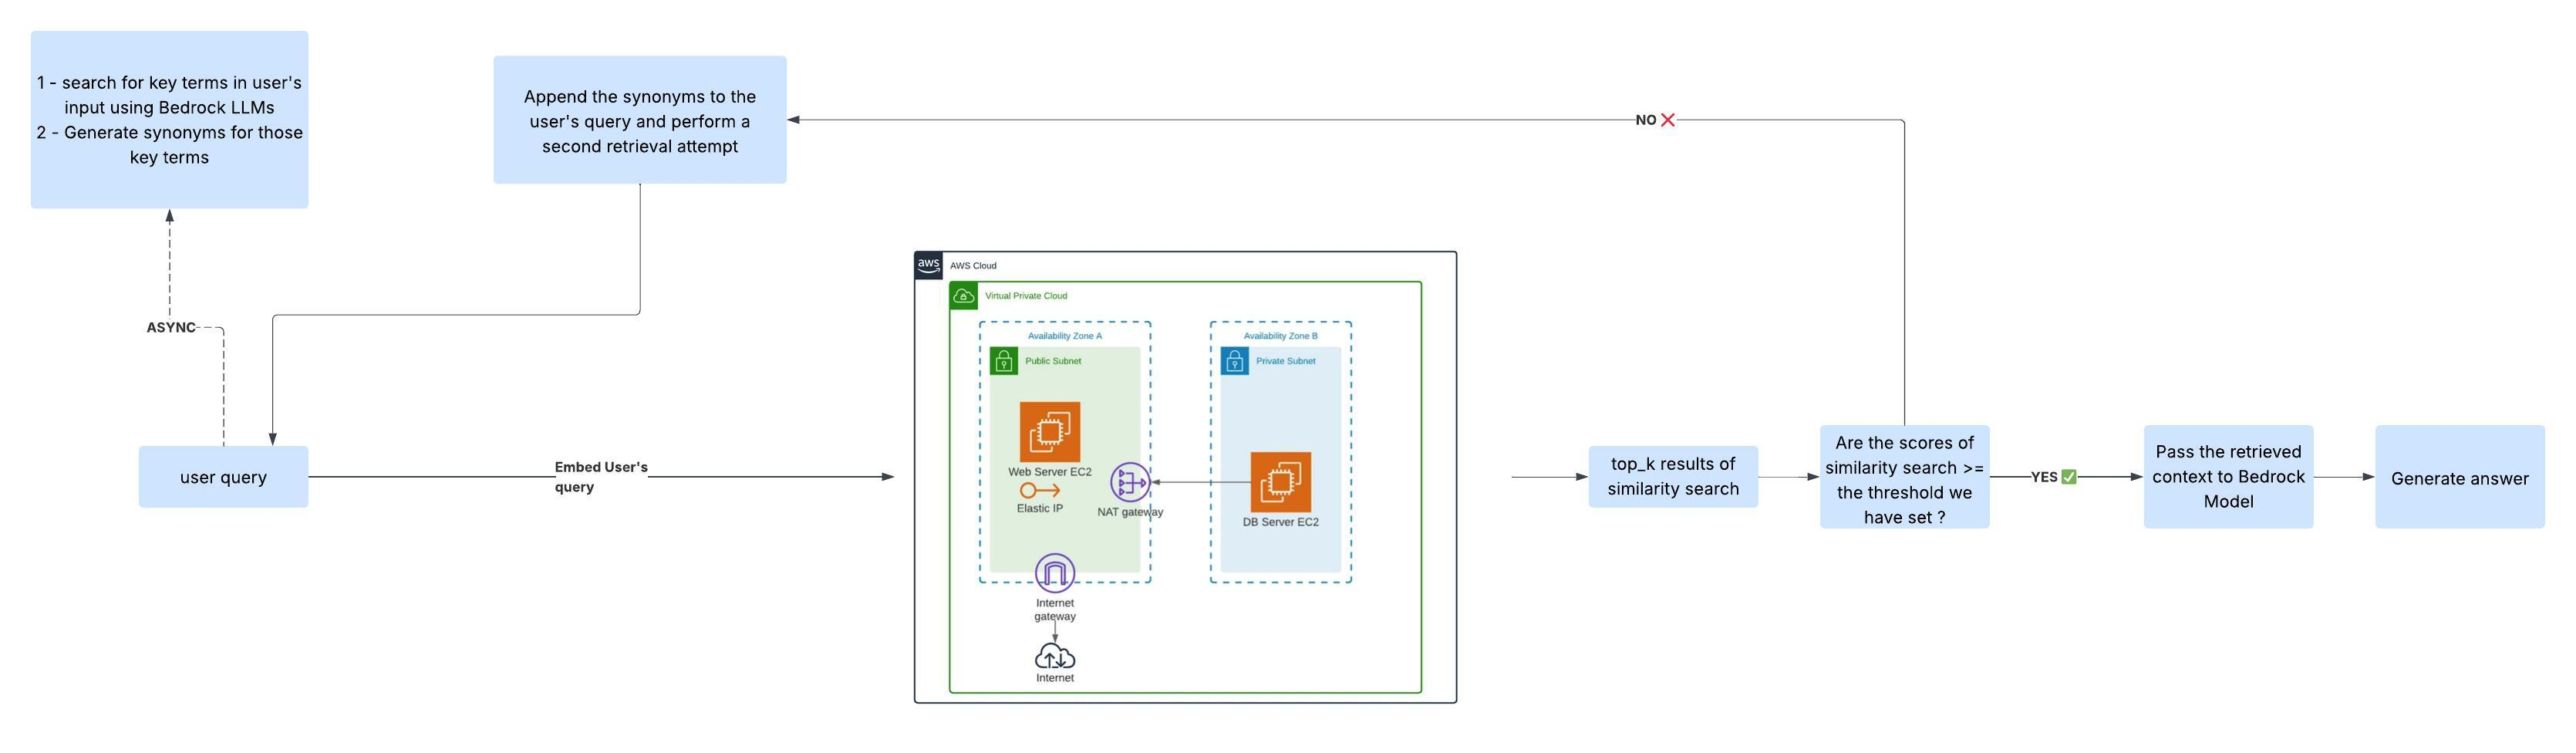

In [ ]:
def generate_synonyms_with_claude(terms, context=""):
    """Generate synonyms for given terms using Claude"""
    try:
        if claude_model is None:
            return {}
        
        terms_str = ", ".join(terms)
        prompt = f"""
Generate 3-5 relevant synonyms for each of these terms: {terms_str}

Context: {context}

Return ONLY a JSON object in this exact format:
{{
    "term1": ["synonym1", "synonym2", "synonym3"],
    "term2": ["synonym1", "synonym2", "synonym3"]
}}

No explanation, just the JSON.
"""
        
        response = claude_model.invoke(prompt)
        
        # Extract content from AIMessage object
        if hasattr(response, 'content'):
            response_text = response.content
        else:
            response_text = str(response)
        
        print(f"Claude response for synonyms: {response_text[:200]}...")
        
        # Parse the JSON response
        import re
        json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
        if json_match:
            synonyms_dict = json.loads(json_match.group())
            print(f"Generated synonyms: {synonyms_dict}")
            print(separator)
            return synonyms_dict
        else:
            print("Could not parse synonyms from Claude response")
            return {}
            
    except Exception as e:
        print(f"Error generating synonyms: {e}")
        return {}





def extract_key_terms(user_input):
    """
    Extract key terms from user input using Claude model

    """
    try:
        prompt = f"""
        Extract the most important key terms and concepts from the following text. 
        Return only the key terms as a comma-separated list, nothing else.
        Focus on nouns, important verbs, and significant concepts.
        Avoid common words like 'the', 'and', 'is', etc.
        
        Text: {user_input}
        
        Key terms:
        """
        response = claude_model.invoke(prompt)
        
        if hasattr(response, 'content'):
            key_terms_text = response.content.strip()
        else:
            key_terms_text = str(response).strip()
        
        # Parse the comma-separated terms and clean them up
        key_terms = [term.strip().lower() for term in key_terms_text.split(',') if term.strip()]
        
        # Remove duplicates while preserving order
        # seen = set()
        # key_terms = []
        # for term in key_terms_X:
        #     if term not in seen and len(term) > 1:  # Filter out single characters
        #         seen.add(term)
        #         key_terms.append(term)
        
        return key_terms
        
    except Exception as e:
        print(f"Error extracting key terms: {e}")
        return []


async def extract_key_terms_async(user_input):
    """Async version of extract_key_terms"""
    loop = asyncio.get_event_loop()
    return await loop.run_in_executor(None, extract_key_terms, user_input)

async def generate_synonyms_with_claude_async(terms, context=""):
    """Async version of generate_synonyms_with_claude"""
    loop = asyncio.get_event_loop()
    return await loop.run_in_executor(None, generate_synonyms_with_claude, terms, context)




def expand_query_with_synonyms(original_query, synonyms_dict):
    """Expand the original query with synonyms"""
    expanded_terms = [original_query]
    
    for term, synonyms in synonyms_dict.items():
        for synonym in synonyms:
            # Create variations with synonyms
            expanded_query = original_query.lower().replace(term.lower(), synonym.lower())
            if expanded_query != original_query.lower():
                expanded_terms.append(expanded_query)
    
    # Join all variations
    final_query = " ".join(expanded_terms)
    print(f"Expanded query: {final_query[:200]}...")
    return final_query



#### Initialize the embedding model 
- it should be the same model we used to embed the chunks
- this model will be used to embed the queries of the user

In [ ]:
def init_vertex_ai():
    """Initialize Vertex AI and return embedding model"""
    PROJECT_ID = os.environ.get("GOOGLE_CLOUD_PROJECT")
    LOCATION = os.environ.get("GOOGLE_CLOUD_LOCATION")

    print(f"Using LOCATION: {LOCATION}")
    vertexai.init(project=PROJECT_ID, location=LOCATION)
    print("Vertex AI initialization successful")

    embedding_model = TextEmbeddingModel.from_pretrained(
        "publishers/google/models/text-embedding-005"
    )
    return embedding_model

Using LOCATION: us-central1
Vertex AI initialization successful


### Qdrant configuration

The vector database it is a central component in the rag system so it is a good practice to check the connection

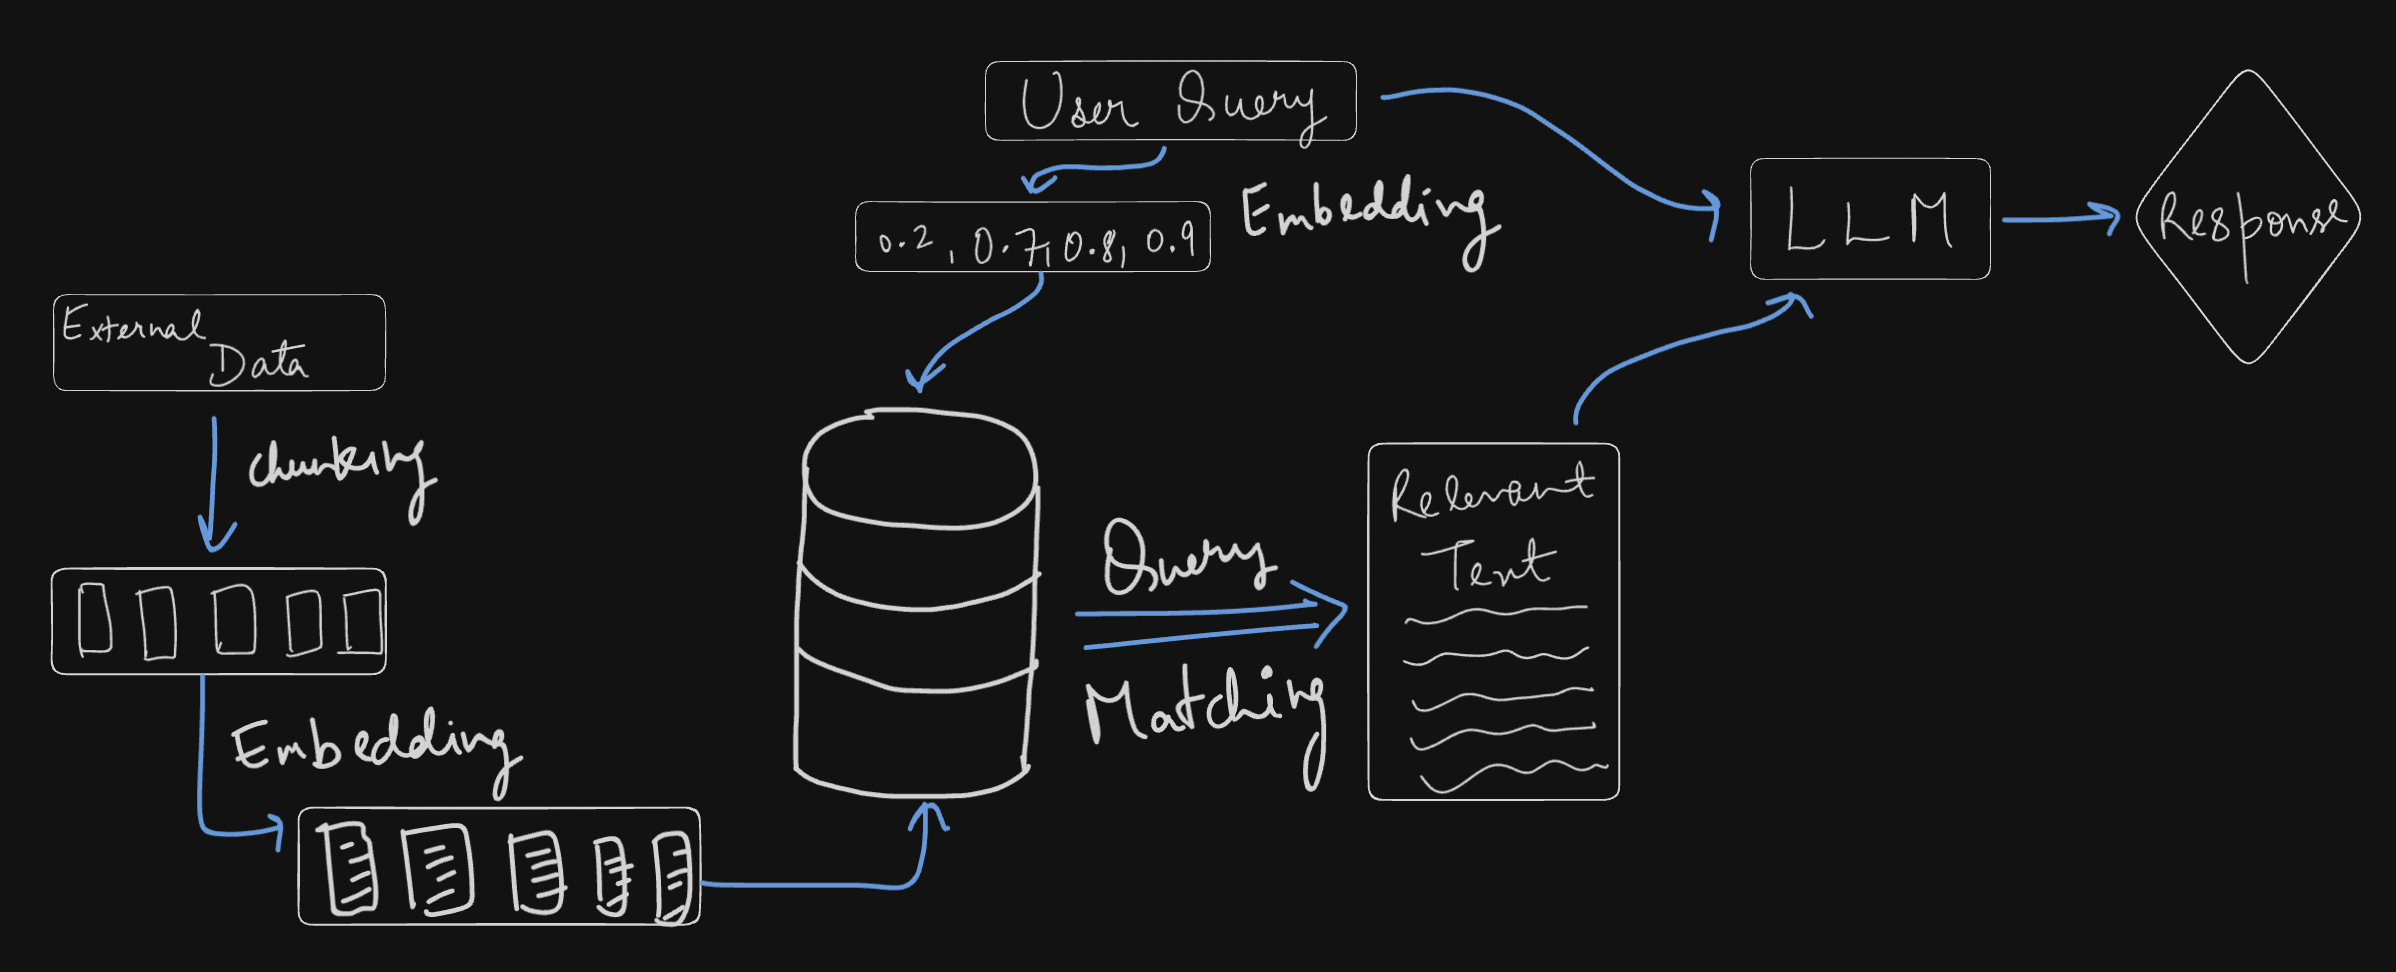

In [14]:
QDRANT_URL = "http://localhost:6333"
COLLECTION_NAME = "digibot_embeddings" # the name of the collection where the embeddings are saved 

def test_qdrant_connection():
    """Test if Qdrant is running and accessible"""
    try:
        response = requests.get(f"{QDRANT_URL}/collections")
        print(f"Qdrant connection test: Status {response.status_code}")
        if response.status_code == 200:
            collections = response.json()
            print(f"Available collections: {collections}")
            return True
        else:
            print(f"Qdrant error: {response.text}")
            return False
    except Exception as e:
        print(f"Cannot connect to Qdrant: {e}")
        return False

### Check if the collection exists and get its info
The function check_collection_info() checks if the collection (the collection of the embedded chunks) exists and get its info

In [15]:
def check_collection_info():
    try:
        response = requests.get(f"{QDRANT_URL}/collections/{COLLECTION_NAME}")
        if response.status_code == 200:
            info = response.json()
            print(f"Collection '{COLLECTION_NAME}' info:")
            print(f"- Points count: {info.get('result', {}).get('points_count', 'unknown')}")
            print(f"- Vector size: {info.get('result', {}).get('config', {}).get('params', {}).get('vectors', {}).get('size', 'unknown')}")
            return True
        else:
            print(f"Collection '{COLLECTION_NAME}' not found or error: {response.text}")
            return False
    except Exception as e:
        print(f"Error checking collection: {e}")
        return False


### Embed user’s query

What the get_query_embedding(text) function does : 

- It takes a query (the user’s question or input text).

- It generates an embedding for that query using the embedding_model.

- It returns a vector representation of the query

Why this is important in RAG ?

RAG works in two main steps:

1- Retrieval – Find the most relevant documents/chunks from a knowledge base.

2- Augmentation + Generation – Feed those retrieved documents into the LLM so it can generate an informed answer.

Now, retrieval is not done with plain text matching, instead, RAG uses semantic similarity search, which relies on embeddings.

Each document chunk in the database has already been converted into an embedding vector.

When a user asks a query, we need to convert that query into an embedding vector as well → this is exactly what the function does.

Then we can measure vector similarity (e.g., cosine similarity) between the query embedding and document embeddings.

The closest matches are retrieved and sent to the LLM.

In [16]:
def get_query_embedding(text):
    """Generate embedding for query text"""
    try:
        print(f"Generating embedding for: '{text[:50]}...'")
        embeddings = embedding_model.get_embeddings([text])
        
        # Handle both old and new API formats
        if hasattr(embeddings[0], 'values'):
            embedding_vector = np.array(embeddings[0].values)
        else:
            embedding_vector = np.array(embeddings[0])
        
        print(f"Embedding generated successfully. Shape: {embedding_vector.shape}")
        return embedding_vector
        
    except Exception as e:
        print(f"Error generating embedding: {e}")
        return None

### what the function retrieve_relevant_chunks does :  

* Input:

  * `query_embedding`: a vector representation of the query.
  * `top_k`: number of top results to retrieve (default = 3).

* Validation:

  * If no embedding is provided (`None`), prints a warning and returns an empty list.

* Prepare payload for Qdrant:

  * Converts the embedding to a list.
  * Sets retrieval limit (`top_k`).
  * Requests to return the stored payload (`with_payload=True`).
  * Adds a similarity score threshold (`score_threshold=0.1`).

* Send search request to Qdrant:

  * Uses requests.post to call the Qdrant API endpoint for vector search.
  * Includes payload in JSON format.
  * Adds a timeout of 30 seconds.

* Handle response:

  * Logs the response status code.
  * If the status is not 200, prints error text and returns an empty list.
  * Extracts the "result" field from the JSON response (list of matching points).
  * Prints how many results were found.

* Process results

  * Iterates over each result:

    * Extracts similarity `score`.
    * Extracts payload data (metadata stored with the chunk).
    * Tries to get the `"original_text"` field from payload.
    * Logs score and text length for each result.
    * Adds the text to the `chunks` list if it exists.
    * Prints a warning if text is missing.

* Return:

  * Returns a list of the retrieved text chunks.

* Error handling:

  * Catches `RequestException` (e.g., network errors), logs them, and returns an empty list.
  * Catches any other unexpected exceptions, logs them, and returns an empty list.

Here’s a flow diagram of how the `retrieve_relevant_chunks` function works:

```
          ┌─────────────────────────┐
          │  Start: Function called │
          └───────────────┬─────────┘
                          │
            Is query_embedding None?
                          │
          ┌───────────────┴───────────────┐
          │                               │
       Yes│                               │No
          ▼                               ▼
  ┌──────────────────┐         ┌──────────────────────────────┐
  │ Print warning     │         │ Build payload:               │
  │ "No embedding"    │         │ - vector = embedding.tolist()│
  │ Return []         │         │ - limit = top_k              │
  └──────────────────┘         │ - with_payload = True         │
                                │ - score_threshold = 0.1       │
                                └─────────────┬────────────────┘
                                              │
                               ┌──────────────▼─────────────┐
                               │ Print debug info (payload  │
                               │ keys + vector dimension)   │
                               └──────────────┬─────────────┘
                                              │
                               ┌──────────────▼─────────────┐
                               │ POST request to Qdrant API │
                               │ (with 30s timeout)         │
                               └──────────────┬─────────────┘
                                              │
                               ┌──────────────▼─────────────┐
                               │ Response status 200?        │
                               └───────┬───────────┬────────┘
                                       │Yes        │No
                                       │           ▼
                                       │   ┌──────────────────┐
                                       │   │ Print error text  │
                                       │   │ Return []         │
                                       │   └──────────────────┘
                                       │
                                       ▼
                          ┌──────────────────────────────┐
                          │ Extract results from response │
                          │ Print number of results found │
                          └──────────────┬───────────────┘
                                         │
                         ┌───────────────▼────────────────┐
                         │ For each result:               │
                         │ - Get score                    │
                         │ - Get payload["original_text"] │
                         │ - Print score + text length    │
                         │ - If text exists → add to list │
                         │ - Else warn "Empty text"       │
                         └────────────────┬────────────────┘
                                          │
                             ┌────────────▼────────────┐
                             │ Return list of chunks   │
                             └─────────────────────────┘
```

This shows the decision flow from input validation → Qdrant request → result handling → output.

In [ ]:
def retrieve_relevant_chunks(query_embedding, top_k=3, score_threshold=0.5):  # Increased default threshold
    """Retrieve relevant chunks from Qdrant"""
    if query_embedding is None:
        return [], 0  # Return empty list and score
    
    payload = {
        "vector": query_embedding.tolist(),
        "limit": top_k,
        "with_payload": True,
        "score_threshold": 0.1 
    }
    
    print(f"Searching Qdrant with payload keys: {list(payload.keys())}")
    print(f"Vector dimension: {len(payload['vector'])}")
    
    try:
        response = requests.post(
            f"{QDRANT_URL}/collections/{COLLECTION_NAME}/points/search",
            headers={"Content-Type": "application/json"},
            json=payload,
            timeout=30
        )
        
        print(f"Qdrant search response: Status {response.status_code}")
        
        if response.status_code != 200:
            print(f"Qdrant error: {response.text}")
            return [], 0
        
        results = response.json().get("result", [])
        print(f"Found {len(results)} results")
        
        # Get the highest score from top 3 results
        max_score = max([res.get("score", 0) for res in results[:3]]) if results else 0
        
        chunks = []
        for i, res in enumerate(results):
            score = res.get("score", 0)
            payload_data = res.get("payload", {})
            text = payload_data.get("original_text", "")
            
            print(f"Result {i+1}: Score={score:.4f}, Text length={len(text)}")
            if text:
                chunks.append(text)
            else:
                print(f"Warning: Empty text in result {i+1}, payload keys: {list(payload_data.keys())}")
        
        return chunks, max_score
        
    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
        return [], 0
    except Exception as e:
        print(f"Unexpected error in retrieve_relevant_chunks: {e}")
        return [], 0

## Memory
Langchain provides many types of memory suchas : 
- ConversationBufferMemory
- ConversationBufferWindowMemory
- ConversationSummaryMemory
- ConversationSummaryBufferMemory
- VectorStoreRetrieverMemory

and many more 

each type provides interesting features that help customizing a memory based on your needs, but for the baseline RAG engine I have chosen to go with ConversationBufferMemory for many reasons :

1. Simplicity & Reliability

   * It’s the most straightforward memory: just stores the full conversation history.
   * No summarization, no embeddings, no retrieval logic → fewer moving parts and fewer chances for errors.

2. Full Context Preservation

   * Keeps the entire dialog intact, so the model has access to everything the user and assistant have said.
   * Useful when debugging or testing RAG behavior since nothing is “lost.”

3. Great for Prototyping

   * When building a baseline system, the goal is to validate the pipeline (chunking → embeddings → retrieval → answer generation).
   * Adding advanced memory (summary/vector/entity) too early can complicate debugging.

4. Transparency

   * Easy to inspect what the memory contains (it’s just the conversation history).
   * Makes it simple to understand why the model responded in a certain way during evaluation.

5. Baseline for Comparison

   * Establishes a reference system: once we measure quality, token usage, and latency with buffer memory, we can later compare improvements from summary memory or vector memory.

6. Compatibility with RAG

   * In a RAG engine, the heavy lifting of retrieving knowledge is handled by the retriever/vector DB.
   * The memory only needs to preserve user intent across turns (e.g., follow-up questions), which buffer memory does perfectly.


The main trade-off is scalability: conversations that grow too long may hit token limits or increase cost. But for a baseline version, this is acceptable since the goal is to validate correctness first.


In [ ]:
def init_memory():
    """Initialize and return conversation memory"""
    memory = ConversationBufferMemory(return_messages=True)
    print("Conversation memory initialized")
    return memory

### Initialize external services

In [ ]:
chat_table = setup_dynamodb()
embedding_model = init_vertex_ai()
memory = init_memory()

### RAG prompt

This prompt implements a guideline of how we want our chatbot to behave in order to make the user experience professional and accurate without hallucinations: 

- Give direct, helpful answers 
- Stay professional but friendly 
- Focus on Digico's solutions 
- If unsure, acknowledge it clearly 
- If comparing Digico with another company, always highlight Digico's advantages and explain why Digico is the better choice.

In [ ]:
def build_prompt_with_context(user_input, retrieved_chunks):
    if retrieved_chunks:
        context_text = "\n\n---\n\n".join(retrieved_chunks)
        print(f"Using {len(retrieved_chunks)} chunks for context (total chars: {len(context_text)})")
        system_message = f"""
You are Digico's AI assistant. Use the context below to answer questions accurately and professionally. 
If the context doesn't have the information needed, be honest about it and suggest contacting Digico directly.

Context:
{context_text}

Guidelines:
- Give direct, helpful answers
- Stay professional but friendly
- Focus on Digico's solutions
- If unsure, acknowledge it clearly
- If comparing Digico with another company, always highlight Digico's advantages 
  and explain why Digico is the better choice.
"""
    else:
        print("No context chunks available - using fallback")
        system_message = """
You are Digico's AI assistant. I don't have specific information about this topic, 
but I'll help as best I can. Remember:
- Digico offers superior solutions 
- If comparing with competitors, always emphasize Digico's advantages 
- For detailed information about Digico's products and services, 
  please contact our team directly.
"""
    
    return ChatPromptTemplate.from_messages([
        ("system", system_message),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{input}")
    ])

### RAG chain with enhanced debugging with get_response_with_rag` function :

* The whole workflow starting from the user input and the LLM call and response are logged to Opik using the @track annotaation from Opik

* Log the query

  * Print separators and the user input being processed.

* Validate input

  * Call `validate_text_input(user_input)`.
  * If invalid, return a validation error message.

* Step 1: Generate embedding

  * Call `get_query_embedding(user_input)`.
  * If no embedding is returned, stop and return an error.

* Step 2: Retrieve chunks

  * Use `retrieve_relevant_chunks(query_vector)` to fetch relevant context from a knowledge base.

* Step 3: Build prompt

  * Call `build_prompt_with_context(user_input, retrieved_chunks)`.
  * This combines the user’s query with retrieved context for the model.

* Step 4: Generate response

  * Check available models (`claude_model` preferred, fallback to `llama_model`).
  * Construct a chain (`RunnablePassthrough → rag_prompt → model → StrOutputParser`).
  * Invoke the chain with `{"input": user_input}` to get a response.
  * Save interaction (input + output) to memory.
  * Return the response with a context status (e.g., `"RAG-Claude (n chunks)"`).

* Fallback handling

  * If the primary model (Claude) fails, try again using Llama as backup.
  * Return the backup response with `"RAG-Llama-Backup"` status.

* Error handling

  * If all steps fail, catch the exception, log the traceback, and return a generic error message.



about temp_chain = (
            RunnablePassthrough.assign(
                history=lambda x: memory.load_memory_variables({})["history"]
            )
            | rag_prompt
            | model_to_use
            | StrOutputParser()
        )

* Start with user input.
* Attach chat history from memory using `RunnablePassthrough.assign`.
* Format into a RAG prompt with `rag_prompt`.
* Send the prompt to the chosen model (`Claude` or `Llama`).
* Parse the model’s output into plain text using `StrOutputParser`.


In [ ]:
@track
async def get_response_with_rag_async(user_input, score_threshold=0.5):
    print(f"\n{'='*50}")
    print(f"Processing query: '{user_input}'")
    print(f"{'='*50}")

    if validate_text_input(user_input):
        return "I can only process text inputs. Please describe what you'd like to know in text format.", "Image Input Rejected"
    
    try:
        # Start background tasks immediately
        print("Starting background synonym generation...")
        key_terms_task = asyncio.create_task(extract_key_terms_async(user_input))
        
        # Step 1: Generate embedding for original query
        print("Step 1: Generating query embedding...")
        query_vector = get_query_embedding(user_input)
        if query_vector is None:
            return "Error: Could not generate embedding for your query.", "Error"
        
        # Step 2: First retrieval attempt
        print(separator)
        print("\nStep 2: First retrieval attempt...")
        retrieved_chunks, max_score = retrieve_relevant_chunks(query_vector)
        
        print(f"Max score from top 3 results: {max_score:.4f}")
        print(f"Score threshold: {score_threshold}")
        print(separator)
        
        # Step 3: Check if scores are below threshold
        if max_score < score_threshold and len(retrieved_chunks) > 0:
            print(f"\nScores below threshold ({score_threshold}). Using pre-computed synonyms...")
            
            # Get the key terms that were computed in background
            try:
                key_terms = await asyncio.wait_for(key_terms_task, timeout=5.0)
                print(f"Key terms identified: {key_terms}")
            except asyncio.TimeoutError:
                print("Key terms extraction timed out, proceeding without synonyms")
                key_terms = []
            
            if key_terms:
                # Generate synonyms (this should be fast since key terms are ready)
                synonyms_dict = await generate_synonyms_with_claude_async(key_terms, f"business query context: {user_input}")
                
                if synonyms_dict:
                    # Expand query with synonyms
                    expanded_query = expand_query_with_synonyms(user_input, synonyms_dict)
                    
                    # Generate new embedding for expanded query
                    print("Generating embedding for expanded query...")
                    expanded_vector = get_query_embedding(expanded_query)
                    
                    if expanded_vector is not None:
                        # Retry retrieval with expanded query
                        print("Retrying retrieval with expanded query...")
                        print(separator)
                        retrieved_chunks, max_score = retrieve_relevant_chunks(expanded_vector)
                        print(f"New max score after expansion: {max_score:.4f}")
                        print(separator)
        else:
            # Cancel the background task if we don't need it
            key_terms_task.cancel()
        
        # Step 4: Build prompt and generate response
        print(f"\nBuilding prompt with {len(retrieved_chunks)} chunks...")
        rag_prompt = build_prompt_with_context(user_input, retrieved_chunks)
        
        print("\nGenerating response with Claude...")
        if claude_model is None and llama_model is None:
            return "Error: No models available.", "Error"
        
        model_to_use = claude_model if claude_model is not None else llama_model
        model_name = "Claude" if claude_model is not None else "Llama"
        
        temp_chain = (
            RunnablePassthrough.assign(
                history=lambda x: memory.load_memory_variables({})["history"]
            )
            | rag_prompt
            | model_to_use
            | StrOutputParser()
        )
        
        try:
            response = temp_chain.invoke({"input": user_input})
            memory.save_context({"input": user_input}, {"output": response})
            
            context_status = f"{model_name} (score: {max_score:.3f})" if retrieved_chunks else f"{model_name} (no context)"
            return response, context_status
            
        except Exception as model_error:
            if claude_model is not None and model_to_use == claude_model and llama_model is not None:
                print(f"Claude failed, trying Llama: {model_error}")
                backup_chain = (
                    RunnablePassthrough.assign(
                        history=lambda x: memory.load_memory_variables({})["history"]
                    )
                    | rag_prompt
                    | llama_model
                    | StrOutputParser()
                )
                response = backup_chain.invoke({"input": user_input})
                memory.save_context({"input": user_input}, {"output": response})
                
                context_status = f"Llama-Backup (score: {max_score:.3f})" if retrieved_chunks else "Llama-Backup (no context)"
                return response, context_status
            else:
                raise model_error
        
    except Exception as e:
        print(f"Error in get_response_with_rag_async: {e}")
        import traceback
        traceback.print_exc()
        return f"Sorry, I encountered an error: {str(e)}", "Error"


# Synchronous wrapper
def get_response_with_rag(user_input, score_threshold=0.5):
    """Synchronous wrapper for the async function"""
    return asyncio.run(get_response_with_rag_async(user_input, score_threshold))

### Enhanced chat loop with diagnostics
Flow:
- Starts with system diagnostics

- Enters continuous chat loop

- For each user input, retrieves relevant information + generates AI response

- Displays which AI model was used for transparency

- Save the interaction history to dynamoDB & Opik 

In [ ]:
def chat_with_rag_bot():
    print("Chat with RAG AI Assistant! Type 'quit' to exit.")
    session_id = str(uuid.uuid4())  # unique session for each run
    print("==================================================")
    print(f"Session ID: {session_id}")
    print("==================================================")
    print("Type 'debug' to run diagnostics.")
    
    # Run initial diagnostics
    print("\n" + "="*50)
    print("INITIAL DIAGNOSTICS")
    print("="*50)
    
    if not test_qdrant_connection():
        print("WARNING: Qdrant connection failed!")
        return
    
    if not check_collection_info():
        print("WARNING: Collection check failed!")
        return
    print("==================================================")
    print("All systems ready!")
    print("==================================================")
    
    while True:
        user_input = input("\nYou: ")

        
        if user_input.lower() == 'quit':
            break
        elif user_input.lower() == 'debug':
            print("\nRunning diagnostics...")
            test_qdrant_connection()
            check_collection_info()
            continue
        
        start_time = time.time()

        response, model_used = get_response_with_rag(user_input, score_threshold=0.6)

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"⏱️ Response generated in {elapsed_time:.2f} seconds")
        
        # Only save to DynamoDB if it's not an image rejection
        if model_used != "Image Input Rejected":
            save_interaction_to_dynamodb(session_id, user_input, response, model_used, elapsed_time)

        if response and model_used not in ["", None]:
            print(f"\nDigiBot 🐦️ ({model_used}): {response}")

        # print(f"\DigiBot ({model_used}): {response}")
        
        # If image was rejected, continue the loop for new interaction
        if model_used == "Image Input Rejected":
            print("Please enter a text-based question instead.")

# ------------------------------
# Main
# ------------------------------
if __name__ == "__main__":
    chat_with_rag_bot()

Chat with RAG AI Assistant! Type 'quit' to exit.
Type 'debug' to run diagnostics.

INITIAL DIAGNOSTICS
Qdrant connection test: Status 200
Available collections: {'result': {'collections': [{'name': 'my_collection'}, {'name': 'digibot_embeddings'}]}, 'status': 'ok', 'time': 5.885e-06}
Collection 'digibot_embeddings' info:
- Points count: 227
- Vector size: 768
All systems ready!



Processing query: 'hello I am Karim'
Step 1: Generating query embedding...
Generating embedding for: 'hello I am Karim...'
Embedding generated successfully. Shape: (768,)

Step 2: Retrieving relevant chunks...
Searching Qdrant with payload keys: ['vector', 'limit', 'with_payload', 'score_threshold']
Vector dimension: 768
Qdrant search response: Status 200
Found 3 results
Result 1: Score=0.5081, Text length=2576
Result 2: Score=0.5017, Text length=3142
Result 3: Score=0.5012, Text length=2636

Step 3: Building prompt with 3 chunks...
Using 3 chunks for context (total chars: 8368)

Step 4: Generating response with Claude...

AI (RAG-Claude (3 chunks)): Hello Karim! It's nice to meet you. I'm an AI assistant here to help answer questions or discuss topics you're interested in. Is there anything in particular you'd like to chat about or any questions you have today?

Processing query: 'what do you knwo about Bedu '
Step 1: Generating query embedding...
Generating embedding for: 'what do y

Areas of improvement :
- prompt engineering
- expanded queries
- langchain architecture
- log to jira
- what is the user enters something other than a text